# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

### Recap of the Titanic exercise

In [1]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('../../data/titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.668161434978


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [2]:
# compute null accuracy manually
print y_test.mean()
print 1 - y_test.mean()

0.42600896861
0.57399103139


In [3]:
# equivalent function in scikit-learn
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print metrics.accuracy_score(y_test, y_dumb_class)

0.57399103139


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [4]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [6]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [9]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [10]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age).T

C:\Users\hansh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [11]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

0.67264573991


## Part 2: Confusion Matrix

In [12]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

In [13]:
# calculate the sensitivity
43 / float(52 + 43)

0.45263157894736844

In [14]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [15]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

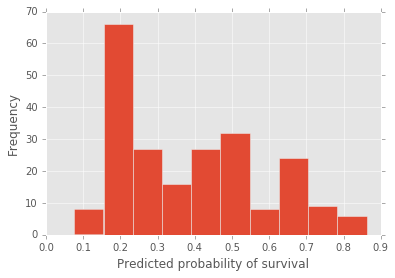

In [17]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [37]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)
print y_pred_class

[1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1
 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0
 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1
 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1
 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0
 1]


In [40]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(-1, 1), 0.25)
print y_pred_class

[[ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]

In [25]:
# new confusion matrix
print metrics.confusion_matrix(y_test, y_pred_class)

[[57 71]
 [27 68]]


In [26]:
# new sensitivity
print 68 / float(27 + 68)

0.715789473684


In [27]:
# new specificity
print 57 / float(57 + 71)

0.4453125


## Part 3: Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding

**Pclass** is an ordered categorical feature, and is already encoded as 1/2/3, so we leave it as-is.

**Sex** is an unordered categorical feature, and needs to be dummy encoded.

### Dummy encoding with two levels

In [28]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [29]:
# include Sex_Female in the model
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Logistic regression coefficients

In [30]:
zip(feature_cols, logreg.coef_[0])

[('Pclass', -1.2209320913215747),
 ('Parch', -0.11739489079983109),
 ('Age', -0.040484266337008495),
 ('Sex_Female', 2.6815252125472218)]

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4$$

In [31]:
# convert log-odds to odds
zip(feature_cols, np.exp(logreg.coef_[0]))

[('Pclass', 0.29495511365485361),
 ('Parch', 0.8892339735062349),
 ('Age', 0.96032427381103702),
 ('Sex_Female', 14.607355636262817)]

Predict probability of survival for **Adam**: first class, no parents or kids, 29 years old, male.

In [32]:
logreg.predict_proba([1, 0, 29, 0])[:, 1]

C:\Users\hansh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.50359593])

### Interpreting the Pclass coefficient

Predict probability of survival for **Bill**: same as Adam, except second class.

In [41]:
logreg.predict_proba([2, 0, 29, 0])[:, 1]

C:\Users\hansh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.23031239])

How could we have calculated that change ourselves using the coefficients?

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

In [42]:
# convert Adam's probability to odds
adamodds = 0.5/(1 - 0.5)

# adjust odds for Bill due to lower class
billodds = adamodds * 0.295

# convert Bill's odds to probability
billodds/(1 + billodds)

0.2277992277992278

### Interpreting the Sex_Female coefficient

Predict probability of survival for **Susan**: same as Adam, except female.

In [43]:
logreg.predict_proba([1, 0, 29, 1])[:, 1]

C:\Users\hansh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.93678482])

Let's calculate that change ourselves:

In [44]:
# adjust odds for Susan due to her sex
susanodds = adamodds * 14.6

# convert Susan's odds to probability
susanodds/(1 + susanodds)

0.9358974358974359

How do we interpret the **Sex_Female coefficient**? For a given Pclass/Parch/Age, being female is associated with an increase in the **log-odds of survival** by 2.68 (or an increase in the **odds of survival** by 14.6) as compared to a male, which is called the **baseline level**.

What if we had reversed the encoding for Sex?

In [45]:
# encode Sex_Male feature
titanic['Sex_Male'] = titanic.Sex.map({'male':1, 'female':0})

In [46]:
# include Sex_Male in the model instead of Sex_Female
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Male']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

[('Pclass', -1.2201766909129148),
 ('Parch', -0.11678129630652558),
 ('Age', -0.040432991181856698),
 ('Sex_Male', -2.6803869181753894)]

The coefficient is the same, except that it's **negative instead of positive**. As such, your choice of category for the baseline does not matter, all that changes is your **interpretation** of the coefficient.

### Dummy encoding with more than two levels

How do we include an unordered categorical feature with more than two levels, like **Embarked**? We can't simply encode it as C=1, Q=2, S=3, because that would imply an **ordered relationship** in which Q is somehow "double" C and S is somehow "triple" C.

Instead, we create **additional dummy variables**:

In [47]:
# create 3 dummy variables
pd.get_dummies(titanic.Embarked, prefix='Embarked').head(10)

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1
6,0,1,0
7,0,0,1
8,0,0,1
9,0,0,1


However, we actually only need **two dummy variables, not three**. Why? Because two dummies captures all of the "information" about the Embarked feature, and implicitly defines C as the **baseline level**.

In [48]:
# create 3 dummy variables, then exclude the first
pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:, 1:].head(10)

,Embarked_Q,Embarked_S
PassengerId,,
1,0,1
2,0,0
3,0,1
4,0,1
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


Here is how we interpret the encoding:

- C is encoded as Embarked_Q=0 and Embarked_S=0
- Q is encoded as Embarked_Q=1 and Embarked_S=0
- S is encoded as Embarked_Q=0 and Embarked_S=1

If this is confusing, think about why we only needed one dummy variable for Sex (Sex_Female), not two dummy variables (Sex_Female and Sex_Male). In general, if you have a categorical feature with **k levels**, you create **k-1 dummy variables**.

In [49]:
# create a DataFrame with the two dummy variable columns
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:, 1:]

# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [50]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female,Sex_Male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,1,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,1,0,1


In [51]:
# include Embarked_Q and Embarked_S in the model
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

[('Pclass', -1.1884986221351446),
 ('Parch', -0.093622382178363953),
 ('Age', -0.040727315628766678),
 ('Sex_Female', 2.6425065647714199),
 ('Embarked_Q', -0.18494075926983072),
 ('Embarked_S', -0.61019906884956532)]

## Part 4: Cross Validation

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.77777778  0.8         0.7752809   0.86516854  0.7752809   0.7752809
  0.78651685  0.7752809   0.80898876  0.81818182]
0.795775734877


### Task: Evaluate each stage of the model with Cross-Validation

In [56]:
feature_cols_list = [['Pclass', 'Parch'], ['Pclass', 'Parch', 'Age'], ['Pclass', 'Parch', 'Age', 'Sex_Female'],
                     ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']]
scores_n = []
scores_n_mean = []

In [57]:
for feature_cols in feature_cols_list:
    X = titanic[feature_cols]
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    scores_n.append(scores)
    scores_n_mean.append(scores.mean())

In [62]:
zip(feature_cols_list, scores_n_mean)

[(['Pclass', 'Parch'], 0.69049341731926017),
 (['Pclass', 'Parch', 'Age'], 0.70276472591079331),
 (['Pclass', 'Parch', 'Age', 'Sex_Female'], 0.79009391669504025),
 (['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S'],
  0.79577573487685849)]

### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

In [53]:
scores_n = []
scores_n_mean = []
n_list = [2, 5, 10, 50]

In [54]:
for n in n_list:
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=n)
    scores_n.append(scores)
    scores_n_mean.append(scores.mean())

In [61]:
zip(n_list, scores_n_mean)

[(2, 0.69049341731926017),
 (5, 0.70276472591079331),
 (10, 0.79009391669504025),
 (50, 0.79577573487685849)]